In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate, GlobalAvgPool2D
from tensorflow.keras.models import Model

# pretrained model: ResNet50
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight


In [40]:
def parse_spectrogram_and_metadata(melspec_path, split_path, metadata_path):
    # Load mel spectrograms
    melspec_dict = np.load(melspec_path, allow_pickle=True).item()

    # Load split and label info
    split_df = pd.read_csv(split_path)
    split_df['key'] = split_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    split_df = split_df.set_index('key')

    # Load downsampled metadata
    meta_df = pd.read_csv(metadata_path)
    meta_df['key'] = meta_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    meta_df = meta_df.set_index('key')

    X_img, X_meta, y, splits = [], [], [], []

    for key in meta_df.index:
        if key not in melspec_dict or key not in split_df.index:
            continue

        img = melspec_dict[key]
        info = split_df.loc[key]
        meta_row = meta_df.loc[key]

        metadata = np.array([
            float(meta_row['latitude']),
            float(meta_row['longitude']),
            float(meta_row['call']),
            float(meta_row['song/canto'])
        ], dtype=np.float32)

        X_img.append(img)
        X_meta.append(metadata)
        y.append(info['y_species_encoded'])
        splits.append(info['split'])

    return np.array(X_img), np.array(X_meta), np.array(y), np.array(splits)


In [41]:
def split_data(X_img, X_meta, y, splits):
    split_map = defaultdict(lambda: ([], [], []))

    for i, split in enumerate(splits):
        split_map[split][0].append(X_img[i])
        split_map[split][1].append(X_meta[i])
        split_map[split][2].append(y[i])

    def to_np(t): return tuple(map(np.array, t))
    return {k: to_np(v) for k, v in split_map.items()}

In [42]:
# data augmentation
def add_random_noise(mels, noise_factor=0.05):
    noise = noise_factor * np.random.randn(*mels.shape)
    return np.clip(mels + noise, 0.0, 1.0).astype(np.float32)

def time_mask(spec, max_width=8):
    t = np.random.randint(0, spec.shape[1] - max_width)
    width = np.random.randint(1, max_width)
    spec[:, t:t+width] = 0
    return spec

def freq_mask(spec, max_height=4):
    f = np.random.randint(0, spec.shape[0] - max_height)
    height = np.random.randint(1, max_height)
    spec[f:f+height, :] = 0
    return spec


def augment_spectrogram(spec):
    spec = add_random_noise(spec)
    spec = time_mask(spec)
    spec = freq_mask(spec)
    spec = spec.astype(np.float32)

    return spec


def image_augment(spec):
    spec = tf.image.random_brightness(spec, max_delta = .1)
    spec = tf.image.random_contrast(spec, .9, 1.1)

    return spec

In [43]:
X_img, X_meta, y, splits = parse_spectrogram_and_metadata(
    melspec_path= "../data/32/birdclef2025_melspec_5sec_32_32.npy",
    split_path= "../data/work_df_w_split_info.csv",
    metadata_path="../data/downsampled_metadata.csv"
)

In [44]:
# resizing image for inceptionv3
IMG_SIZE = 224

def preprocess_spec(img):
    img = tf.cast(img, tf.float32)
    img = img[..., tf.newaxis] # to get (32, 32, 1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) # (224, 224, 1) or 128 for effnet
    img = tf.image.grayscale_to_rgb(img) # now (224, 224, 3)

    return img

In [45]:

def make_tf_dataset(X_img, X_meta, y, batch_size = 32, augment = False, shuffle = True):

    def map_fn(img, meta, label):

        if augment:
            img = tf.numpy_function(augment_spectrogram, [img], tf.float32)
            img.set_shape([32, 32])

            
        img = preprocess_spec(img)
    
        return {"image": img, "metadata": tf.cast(meta, tf.float32)}, tf.one_hot(label, num_classes)

    
    ds = tf.data.Dataset.from_tensor_slices((X_img, X_meta, y))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(X_img))
        
    ds = ds.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)


    return ds
        

In [61]:
def build_simple_effnet_model(img_shape, meta_features_num, num_classes, fine_tune=False, fine_tune_at=None):
    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    # Image input: spectrogram (grayscale) resized to 128x128x3
    img_input = Input(shape=img_shape, name="image")
    
    x = layers.Rescaling(1./255)(img_input)           # Normalize to 0–1
    x = layers.Lambda(preprocess_input)(x)    # EfficientNet preprocessing

    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x)
    
    # Fine-tune setup
    if fine_tune:
        base_model.trainable = True
        if fine_tune_at:
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
    else:
        base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)


    # Metadata branch
    meta_input = Input(shape=(meta_features_num,), name="metadata")
    m = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(meta_input)
    m = layers.Dropout(0.5)(m)

    # Combine image + metadata
    combined = layers.Concatenate()([x, m])
    z = layers.Dense(128, activation="relu")(combined)
    z = layers.Dropout(0.5)(z)

    output = layers.Dense(num_classes, activation="softmax")(z)

    model = Model(inputs={"image": img_input, "metadata": meta_input}, outputs=output)

    # Learning rate schedule: lower LR if fine-tuning
    initial_lr = 1e-5 if fine_tune else 1e-3
    lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr, decay_steps=1000, decay_rate=0.9)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )

    return model

In [47]:
def build_effnet_model(img_shape, meta_features_num, num_classes, fine_tune=False, fine_tune_at=None):
    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    # Image input: spectrogram (grayscale) resized to 128x128x3
    img_input = Input(shape=img_shape, name="image")
    
    x = layers.Rescaling(1./255)(img_input)           # Normalize to 0–1
    x = layers.Lambda(preprocess_input)(x)    # EfficientNet preprocessing

    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x)
    
    # Fine-tune setup
    if fine_tune:
        base_model.trainable = True
        if fine_tune_at:
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
    else:
        base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Metadata branch
    meta_input = Input(shape=(meta_features_num,), name="metadata")
    m = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(meta_input)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(0.3)(m)

    # Combine image + metadata
    combined = layers.Concatenate()([x, m])
    z = layers.Dense(128, activation="relu")(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.3)(z)
    z = layers.Dense(64, activation="relu")(z)
    output = layers.Dense(num_classes, activation="softmax")(z)

    model = Model(inputs={"image": img_input, "metadata": meta_input}, outputs=output)

    # Learning rate schedule: lower LR if fine-tuning
    initial_lr = 1e-5 if fine_tune else 1e-3
    lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr, decay_steps=1000, decay_rate=0.9)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )

    return model

In [48]:
def build_inception_model(img_shape, meta_features_num, num_classes, fine_tune = False, fine_tune_at = None):

    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    # image input
    img_input = Input(shape = img_shape, name = "image")

    base_model = InceptionV3(include_top=False, weights = 'imagenet', input_tensor=img_input)
    
    # freeze/unfreeze based on fine-tuning flag
    if fine_tune:
        base_model.trainable = True
        if fine_tune_at is not None:
            # freeze all layers up to fine_tune_at
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
        else: 
            base_model.trainable = fine_tune


    x = GlobalAvgPool2D()(base_model.output)
    x = layers.Dense(256, activation = "relu", kernel_regularizer = regularizers.l2(.001))(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Dropout(.3)(x)

    # metadata input
    meta_input = Input(shape = (meta_features_num, ), name = "metadata")
    m = Dense(64, activation = "relu",
              kernel_regularizer = regularizers.l2(.001))(meta_input)
    # m = layers.BatchNormalization()(m)
    m = Dropout(.3)(m)

    # soft attention over metadata - adapted from Denvir's code
    attention = layers.Dense(64, activation = "sigmoid")(m)
    m = layers.Multiply()([m, attention])

    m = layers.Dense(32, activation = "relu",
                     kernel_regularizer = regularizers.l2(.001))(m)
    # m = layers.BatchNormalization()(m)
    m = layers.Dropout(.3)(m)

    # now combining cnn & metadata
    combined = Concatenate()([x, m])

    z = layers.Dense(128, activation = "relu",
                     kernel_regularizer = regularizers.l2(.001))(combined)
    # z = layers.BatchNormalization()(z)
    z = layers.Dropout(.5)(z)

    z = layers.Dense(64, activation = "relu")(z)
    z = layers.Dropout(.3)(z)
    
    output = layers.Dense(num_classes, activation = "softmax")(z)

    model = Model(inputs = {"image": img_input, "metadata": meta_input}, outputs = output)

    # learning rate schedule - using smaller lr if fine-tuning
    initial_lr = 1e-5 if fine_tune else 1e-3
    lr_schedule = ExponentialDecay(
        initial_learning_rate = initial_lr,
        decay_steps = 1000,
        decay_rate = .9
    )


    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # compile model
    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing= .1),
                  metrics = ["accuracy"])

    return model

In [49]:
# modified from Denvir's code

data_splits = split_data(X_img, X_meta, y, splits)

X_train_img, X_train_meta, y_train = data_splits['train']
X_val_img, X_val_meta, y_val = data_splits['val']
X_test_img, X_test_meta, y_test = data_splits['test']

# Omit adding channel dimension to spectrograms
# X_train_img = X_train_img[..., np.newaxis]  # becomes (259, 32, 32, 1)
# X_val_img = X_val_img[..., np.newaxis]
# X_test_img = X_test_img[..., np.newaxis]

X_train_img = X_train_img.astype(np.float32)
X_val_img = X_val_img.astype(np.float32)
X_test_img = X_test_img.astype(np.float32)

X_train_meta = X_train_meta.astype(np.float32)
X_val_meta = X_val_meta.astype(np.float32)
X_test_meta = X_test_meta.astype(np.float32)

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

print(X_train_img.shape)  # --> (N, 256, 256, 1)
print(X_train_meta.shape) # --> (N, 4)
print(y_train.shape)      # --> (N,)

print(X_test_img.shape, X_test_meta.shape, y_test.shape) # check for none
print(np.any(X_test_img == None), np.any(X_test_meta == None), np.any(y_test == None))


(259, 32, 32)
(259, 4)
(259,)
(68, 32, 32) (68, 4) (68,)
False False False


In [50]:
len(np.unique(y))

4

In [51]:
num_classes = len(np.unique(y))

In [52]:
train_ds = make_tf_dataset(X_train_img, X_train_meta, y_train, augment = True, shuffle = True)
val_ds = make_tf_dataset(X_val_img, X_val_meta, y_val, augment=False, shuffle=False)
test_ds = make_tf_dataset(X_test_img, X_test_meta, y_test, augment = False, shuffle=False)

In [53]:
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_val_oh = to_categorical(y_val, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

In [54]:
scaler = StandardScaler()
X_train_meta = scaler.fit_transform(X_train_meta)
X_val_meta = scaler.transform(X_val_meta)
X_test_meta = scaler.transform(X_test_meta)

In [55]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [56]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

In [57]:
print(X_train_meta.shape)

meta_features_num = X_train_meta.shape[1]


(259, 4)


In [58]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
img_shape

(224, 224, 3)

In [59]:
model_base = build_effnet_model(
    img_shape=img_shape,
    meta_features_num=meta_features_num,
    num_classes=num_classes,
    fine_tune = False
)

In [60]:
model_base.fit(
    train_ds,
    validation_data = val_ds,
    class_weight = class_weights,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2702 - loss: 1.8028 - val_accuracy: 0.2466 - val_loss: 3.1901
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 839ms/step - accuracy: 0.3181 - loss: 1.5954 - val_accuracy: 0.2466 - val_loss: 3.3555
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4301 - loss: 1.3892 - val_accuracy: 0.2466 - val_loss: 2.7532
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 933ms/step - accuracy: 0.4887 - loss: 1.2998 - val_accuracy: 0.2466 - val_loss: 2.1404
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 849ms/step - accuracy: 0.4310 - loss: 1.4165 - val_accuracy: 0.2466 - val_loss: 2.0196
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 849ms/step - accuracy: 0.4563 - loss: 1.2641 - val_accuracy: 0.2877 - val_loss: 1.9837
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 917ms/step - accuracy: 0.4287 - loss: 1.3167 - val_accuracy: 0.2877 - val_loss: 1.9174
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 883ms/step - accuracy: 0.4488 - loss: 1.3057 - val_accuracy: 0.2877 - val_loss: 1.84

In [62]:
test_loss, test_acc = model_base.evaluate(test_ds)
val_loss, val_acc = model_base.evaluate(val_ds)
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")
print(f"val loss: {val_loss:.2f}, val accuracy: {val_acc:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 486ms/step - accuracy: 0.2858 - loss: 1.8187
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 483ms/step - accuracy: 0.2405 - loss: 1.9293
test loss: 1.71, test accuracy: 0.35
val loss: 1.87, val accuracy: 0.30


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step  


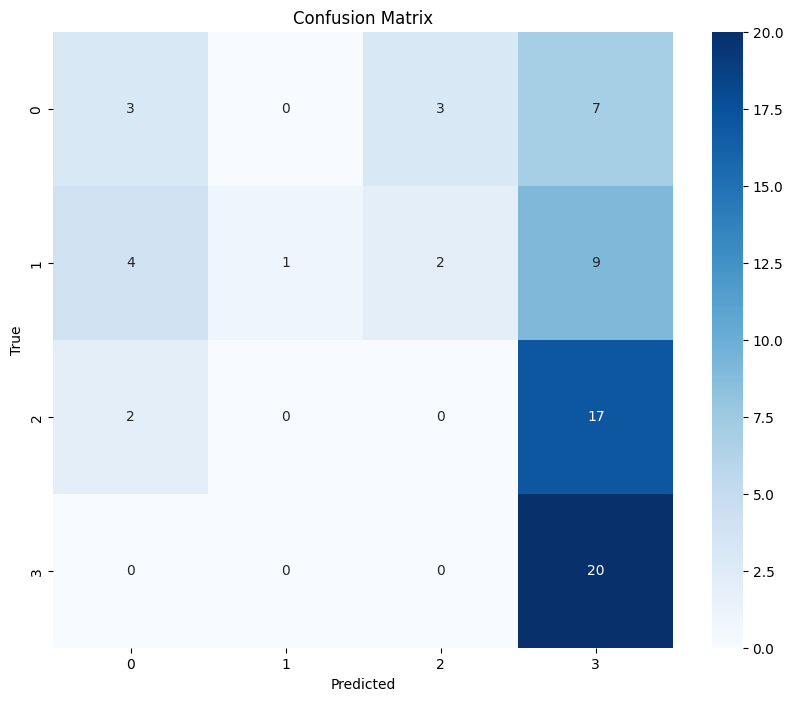

In [63]:
y_pred_prob = model_base.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [64]:
model_ft2 = build_effnet_model(
    img_shape = img_shape,
    meta_features_num=meta_features_num,
    num_classes=num_classes,
    fine_tune=True,
    fine_tune_at=200
)

In [65]:
model_ft2.fit(
    train_ds,
    validation_data = val_ds,
    class_weight = class_weights,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.2005 - loss: 2.1657

9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2044 - loss: 2.1594 - val_accuracy: 0.2055 - val_loss: 1.7271
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.2485 - loss: 2.0078

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2492 - loss: 2.0046 - val_accuracy: 0.2466 - val_loss: 1.6547
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2487 - loss: 2.1180

9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.2470 - loss: 2.1158 - val_accuracy: 0.2466 - val_loss: 1.6183
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2549 - loss: 1.9693

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.2560 - loss: 1.9662 - val_accuracy: 0.2603 - val_loss: 1.6091
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3084 - loss: 2.0251 - val_accuracy: 0.2740 - val_loss: 1.6098
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2560 - loss: 1.9863 - val_accuracy: 0.2877 - val_loss: 1.6139
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2872 - loss: 1.8860 - val_accuracy: 0.2877 - val_loss: 1.6231
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2377 - loss: 2.1080 - val_accuracy: 0.1918 - val_loss: 1.6358
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3013 - loss: 1.8679 - val_accuracy: 0.2055 - val_loss: 1.6523
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2579 - loss: 1.9361 - val_accuracy: 0.2055 - val_loss: 1.6641
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2565 - loss: 2.0578 - val_accuracy: 0.2466 - val_loss: 1.6772
Epoch 12/50
9/9 ━━━━━

In [66]:
test_loss, test_acc = model_ft2.evaluate(test_ds)
val_loss, val_acc = model_ft2.evaluate(val_ds)

print(f"val loss: {val_loss:.2f}, val accuracy: {val_acc:.2f}")
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step - accuracy: 0.2564 - loss: 1.4731
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - accuracy: 0.2122 - loss: 1.7163
val loss: 1.61, val accuracy: 0.26
test loss: 1.43, test accuracy: 0.29


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x38889c700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step  


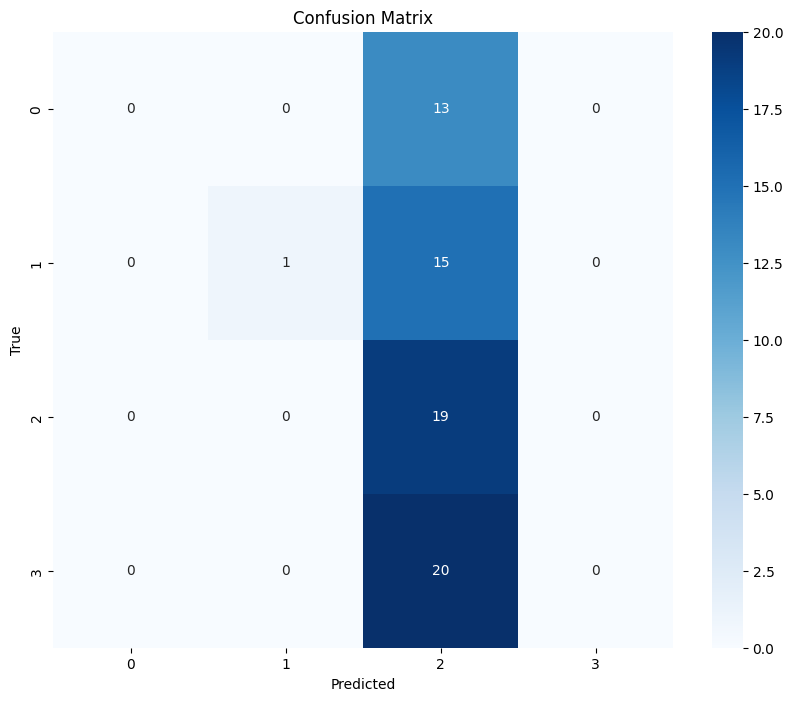

In [67]:
y_pred_prob = model_ft2.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [68]:
# Get predicted class indices
y_pred_prob = model_ft2.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       1.00      0.06      0.12        16
           2       0.28      1.00      0.44        19
           3       0.00      0.00      0.00        20

    accuracy                           0.29        68
   macro avg       0.32      0.27      0.14        68
weighted avg       0.31      0.29      0.15        68



/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is il

In [69]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)

model_inc_base = build_inception_model(
    img_shape=img_shape,
    meta_features_num=meta_features_num,
    num_classes=num_classes,
    fine_tune = False
)

In [70]:
model_inc_base.fit(
    train_ds,
    validation_data = val_ds,
    class_weight = class_weights,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/50


9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.1974 - loss: 5.5908 - val_accuracy: 0.2603 - val_loss: 3.4696
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - accuracy: 0.2555 - loss: 3.1695 - val_accuracy: 0.2466 - val_loss: 8.7884
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.2998 - loss: 2.4363 - val_accuracy: 0.2466 - val_loss: 4.9785
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - accuracy: 0.2844 - loss: 2.3723 - val_accuracy: 0.2740 - val_loss: 3.1060
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.3434 - loss: 2.1564 - val_accuracy: 0.1644 - val_loss: 2.7068
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.2559 - loss: 2.2422 - val_accuracy: 0.2740 - val_loss: 4.5930
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.2703 - loss: 2.1084 - val_accuracy: 0.2740 - val_loss: 3.4564
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.2503 - loss: 2.1057 - val_accuracy: 0.2740 - val_loss: 2.3939
Epoch 9/50
9/9 ━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.3882 - loss: 1.6769 - val_accuracy: 0.4247 - val_loss: 1.6068
Epoch 34/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - accuracy: 0.3517 - loss: 1.6130 - val_accuracy: 0.3973 - val_loss: 1.6534
Epoch 35/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.3593 - loss: 1.6345 - val_accuracy: 0.4795 - val_loss: 1.6198
Epoch 36/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.3860 - loss: 1.6136 - val_accuracy: 0.5342 - val_loss: 1.6077
Epoch 37/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.4078 - loss: 1.5694 - val_accuracy: 0.4247 - val_loss: 1.6140
Epoch 38/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3264 - loss: 1.6557

9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.3258 - loss: 1.6555 - val_accuracy: 0.4247 - val_loss: 1.5856
Epoch 39/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3283 - loss: 1.5898

9/9 ━━━━━━━━━━━━━━━━━━━━ 62s 7s/step - accuracy: 0.3291 - loss: 1.5897 - val_accuracy: 0.4247 - val_loss: 1.5456
Epoch 40/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3927 - loss: 1.5808

9/9 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.3975 - loss: 1.5802 - val_accuracy: 0.4658 - val_loss: 1.5446
Epoch 41/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3710 - loss: 1.5954

9/9 ━━━━━━━━━━━━━━━━━━━━ 70s 8s/step - accuracy: 0.3710 - loss: 1.5939 - val_accuracy: 0.4110 - val_loss: 1.5279
Epoch 42/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3259 - loss: 1.6114

9/9 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.3273 - loss: 1.6086 - val_accuracy: 0.4384 - val_loss: 1.5158
Epoch 43/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 61s 7s/step - accuracy: 0.3527 - loss: 1.5602 - val_accuracy: 0.3973 - val_loss: 1.6715
Epoch 44/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.3658 - loss: 1.5556 - val_accuracy: 0.4110 - val_loss: 1.6182
Epoch 45/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.3362 - loss: 1.5882 - val_accuracy: 0.3836 - val_loss: 1.5922
Epoch 46/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.3969 - loss: 1.5690 - val_accuracy: 0.3973 - val_loss: 1.5274
Epoch 47/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.4319 - loss: 1.5480 - val_accuracy: 0.3836 - val_loss: 1.5580
Epoch 48/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.4217 - loss: 1.5395 - val_accuracy: 0.4110 - val_loss: 1.5453
Epoch 49/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.4760 - loss: 1.5157 - val_accuracy: 0.3425 - val_loss: 1.5395
Epoch 50/50


In [72]:
test_loss, test_acc = model_inc_base.evaluate(test_ds)
val_loss, val_acc = model_inc_base.evaluate(val_ds)

print(f"val loss: {val_loss:.2f}, val accuracy: {val_acc:.2f}")
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 846ms/step - accuracy: 0.4251 - loss: 1.6175
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 999ms/step - accuracy: 0.4262 - loss: 1.5245
val loss: 1.52, val accuracy: 0.44
test loss: 1.63, test accuracy: 0.40


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        13
           1       0.28      0.69      0.39        16
           2       0.00      0.00      0.00        19
           3       0.91      0.50      0.65        20

    accuracy                           0.40        68
   macro avg       0.38      0.41      0.36        68
weighted avg       0.40      0.40      0.36        68



/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/woojungkim/Library/Caches/pypoetry/virtualenvs/datasci207-bird-sounds-l5dSQ9Ay-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is il

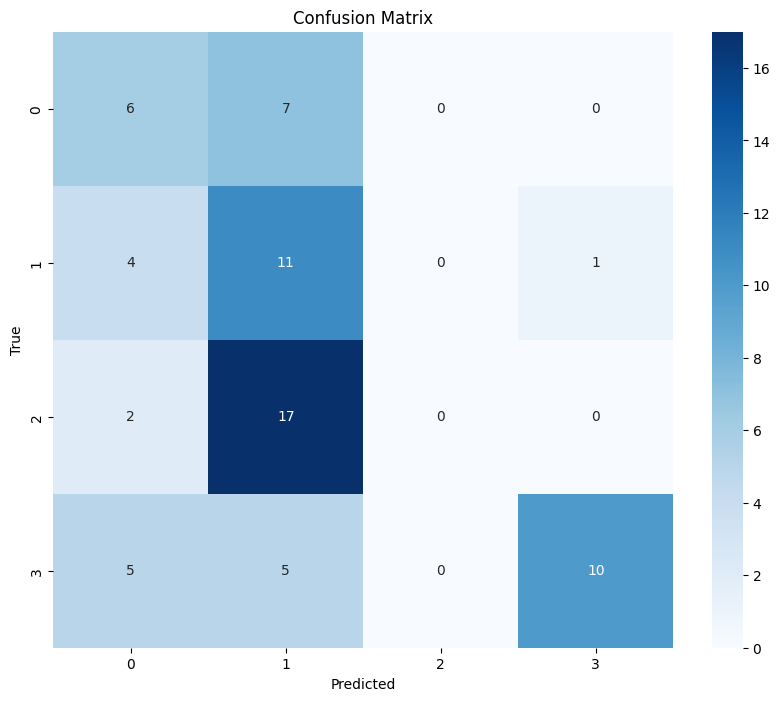

In [74]:
# Get predicted class indices
y_pred_prob = model_inc_base.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_effnet = build_effnet_model(
    img_shape = img_shape,
    meta_features_num=meta_features_num,
    num_classes=num_classes
)

In [ ]:
model_effnet.fit(train_ds,
    validation_data = val_ds,
    class_weight = class_weights,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2368 - loss: 6.2405 - val_accuracy: 0.4384 - val_loss: 2.2360
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 937ms/step - accuracy: 0.2124 - loss: 5.1701 - val_accuracy: 0.4932 - val_loss: 1.5947
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.3098 - loss: 3.6230

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3081 - loss: 3.6196 - val_accuracy: 0.4795 - val_loss: 1.3856
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.3021 - loss: 3.0268

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3012 - loss: 3.0182 - val_accuracy: 0.4795 - val_loss: 1.3161
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3475 - loss: 2.7403 - val_accuracy: 0.3699 - val_loss: 1.4043
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3540 - loss: 2.5608 - val_accuracy: 0.3836 - val_loss: 1.5440
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 832ms/step - accuracy: 0.3057 - loss: 2.3160 - val_accuracy: 0.3836 - val_loss: 1.4490
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 913ms/step - accuracy: 0.3085 - loss: 2.0014 - val_accuracy: 0.3973 - val_loss: 1.3645
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 918ms/step - accuracy: 0.3320 - loss: 1.9338 - val_accuracy: 0.3836 - val_loss: 1.3417
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.3630 - loss: 1.7046

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 919ms/step - accuracy: 0.3622 - loss: 1.7085 - val_accuracy: 0.3699 - val_loss: 1.3091
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3391 - loss: 1.7295 - val_accuracy: 0.3562 - val_loss: 1.3324
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3171 - loss: 1.8353 - val_accuracy: 0.3699 - val_loss: 1.3323
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3536 - loss: 1.6280 - val_accuracy: 0.3288 - val_loss: 1.3159
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2907 - loss: 1.7079 - val_accuracy: 0.4932 - val_loss: 1.3394
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2864 - loss: 1.5998 - val_accuracy: 0.4384 - val_loss: 1.3477
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 938ms/step - accuracy: 0.3550 - loss: 1.5719 - val_accuracy: 0.3699 - val_loss: 1.3719
Epoch 17/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 819ms/step - accuracy: 0.2975 - loss: 1.5690 - val_accuracy: 0.3014 - val_loss: 1.4088
Epoch 1

In [ ]:
test_loss, test_acc = model_effnet.evaluate(test_ds)
val_loss, val_acc = model_effnet.evaluate(val_ds)

print(f"val loss: {val_loss:.2f}, val accuracy: {val_acc:.2f}")
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 504ms/step - accuracy: 0.3440 - loss: 1.2876
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.3412 - loss: 1.3004
val loss: 1.31, val accuracy: 0.37
test loss: 1.29, test accuracy: 0.37
